In [ ]:
!pip install --upgrade timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 35.6 MB/s eta 0:00:00


In [ ]:
import torch
from torch import nn
import os
import random
from PIL import Image
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from timeit import default_timer as timer
import torchvision
import timm
import shutil
torch.__version__

'2.4.1+cu121'

In [ ]:
# Setup the device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Importing the dataset from kaggle to colab

Dataset Link: https://www.kaggle.com/datasets/himanshuydv11/facial-emotion-dataset

In [ ]:
from google.colab import files
files.upload()

"""
Note: once you run this cell it should ask you to upload Kaggle's API
      token(kaggle.json) file.

      Please do the following to download the API token from Kaggle:
       1. Go to your Kaggle account settings by clicking on your profile picture
          and selecting "Account."
       2. Scroll down to the API section and click on Create New API Token.
          This will download a file called kaggle.json.

      After doing above you'll be able to upload the kaggle's api token from
      your local machine to colab, just select the file where you've downloaded it.
"""

Saving kaggle.json to kaggle.json


'\nNote: once you run this cell it should ask you to upload Kaggle\'s API\n      token(kaggle.json) file.\n\n      Please do the following to download the API token from Kaggle:\n       1. Go to your Kaggle account settings by clicking on your profile picture\n          and selecting "Account."\n       2. Scroll down to the API section and click on Create New API Token.\n          This will download a file called kaggle.json.\n\n      After doing above you\'ll be able to upload the kaggle\'s api token from\n      your local machine to colab, just select the file where you\'ve downloaded it.\n'

In [ ]:
# Kaggle API Configuration
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download the dataset from kaggle using kaggle's api-command
!kaggle datasets download -d himanshuydv11/facial-emotion-dataset

Dataset URL: https://www.kaggle.com/datasets/himanshuydv11/facial-emotion-dataset
License(s): unknown
 99% 1.97G/1.98G [00:23<00:00, 122MB/s]
100% 1.98G/1.98G [00:23<00:00, 91.3MB/s]


In [ ]:
!rm -r facial_emotion_dataset

In [ ]:
!unzip -o facial-emotion-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: facial_emotion_dataset/dataset/Sad/0a12a7e998fa7abde73e79ce2a74477bdc6f5dd010da05231f4c3330.jpg  
  inflating: facial_emotion_dataset/dataset/Sad/0a1370fc7e34586d5f134694c9d1e79ed4cce9e59684077ae5061db8.png  
  inflating: facial_emotion_dataset/dataset/Sad/0a14abb2a25753914205e88e870054918de36219552002f3144b8455.jpg  
  inflating: facial_emotion_dataset/dataset/Sad/0a15eede4e05e13f70f6540c4167282f9a488cc318005c8693c49433.jpg  
  inflating: facial_emotion_dataset/dataset/Sad/0a163aa46984ad37b58aa6b8175dca9b1007a3066099d18f4dda6f78.jpg  
  inflating: facial_emotion_dataset/dataset/Sad/0a1833eb2427bd8c1ddd3b9c020c6233a3671763e21b1e08b5afa41f.jpg  
  inflating: facial_emotion_dataset/dataset/Sad/0a19842e87935fbd2c45a7042e4bb8d1d3816476e8a6b7e8f41205d8.jpg  
  inflating: facial_emotion_dataset/dataset/Sad/0a1d613237e9af295213c61e1c2b9d7fd211fad638c522afb9548901.jpg  
  inflating: facial_emotion_dataset/dataset/Sad/0a1d86074a08f

## Data Exploration and walkthrough

In [ ]:
def walkthrough_dir(dir_path: str) -> None:
  """
  Gives an overview of the directory(dir_path) returning it's contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    None: This function does not reutrn a value.
          Instead it prints following:
            number of subdiretories in dir_path
            number of images (files) in each subdirectory
            name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


In [ ]:
walkthrough_dir("/content/facial_emotion_dataset/")

There are 1 directories and 1 images in '/content/facial_emotion_dataset/'.
There are 6 directories and 0 images in '/content/facial_emotion_dataset/dataset'.
There are 0 directories and 3934 images in '/content/facial_emotion_dataset/dataset/Sad'.
There are 0 directories and 1205 images in '/content/facial_emotion_dataset/dataset/Ahegao'.
There are 0 directories and 3740 images in '/content/facial_emotion_dataset/dataset/Happy'.
There are 0 directories and 1313 images in '/content/facial_emotion_dataset/dataset/Angry'.
There are 0 directories and 4027 images in '/content/facial_emotion_dataset/dataset/Neutral'.
There are 0 directories and 1234 images in '/content/facial_emotion_dataset/dataset/Surprise'.


In [ ]:
# Set your dataset path and the new directory for train and test splits
dataset_path = '/content/facial_emotion_dataset/dataset'  # Update this to your dataset path
train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')

# Create the train and test directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get all classes (subdirectories)
all_classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

# Filter out any directories that are 'train' or 'test'
all_classes = [cls for cls in all_classes if cls not in ['train', 'test']]

# Split data
for cls in all_classes:
    class_path = os.path.join(dataset_path, cls)
    files = os.listdir(class_path)
    random.shuffle(files)

    # Define the number of files to split (80% train, 20% test)
    split_index = int(len(files) * 0.8)

    # Create class-specific directories in train and test if they don't exist
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

    # Move files to train and test directories
    for file in files[:split_index]:
        shutil.move(os.path.join(class_path, file), os.path.join(train_dir, cls, file))

    for file in files[split_index:]:
        shutil.move(os.path.join(class_path, file), os.path.join(test_dir, cls, file))

    print(f'Processed class: {cls}, Total files: {len(files)}, '
          f'Moved {split_index} files to train/{cls}, {len(files) - split_index} files to test/{cls}')

Processed class: Sad, Total files: 3934, Moved 3147 files to train/Sad, 787 files to test/Sad
Processed class: Ahegao, Total files: 1205, Moved 964 files to train/Ahegao, 241 files to test/Ahegao
Processed class: Happy, Total files: 3740, Moved 2992 files to train/Happy, 748 files to test/Happy
Processed class: Angry, Total files: 1313, Moved 1050 files to train/Angry, 263 files to test/Angry
Processed class: Neutral, Total files: 4027, Moved 3221 files to train/Neutral, 806 files to test/Neutral
Processed class: Surprise, Total files: 1234, Moved 987 files to train/Surprise, 247 files to test/Surprise


Random train image path: /content/facial_emotion_dataset/dataset/train/Sad/2d3a1584636847396ff4edf0bb8f2b8c790ec6ffba428fdbf410f1eb.jpg
Image class: Sad
Image height: 791
Image width: 791


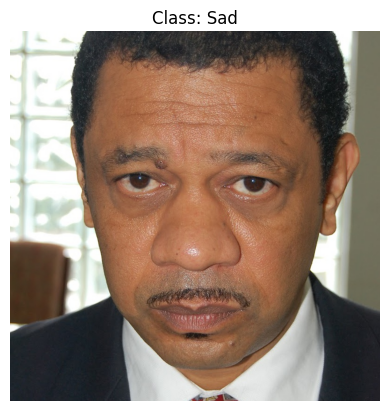

Random test image path: /content/facial_emotion_dataset/dataset/test/Angry/cropped_emotions.232166~angry.png
Image class: Angry
Image height: 245
Image width: 194


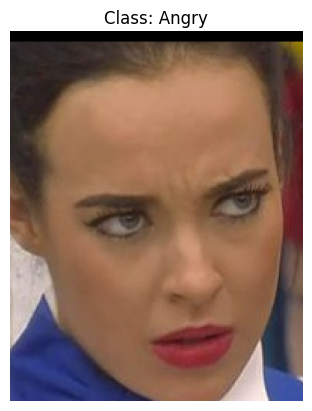

In [ ]:

def visualize_random_image(dataset_path, dataset_type):
    """
    Visualizes a random image from the specified dataset type (train/test).

    Args:
        dataset_path (str): Path to the dataset.
        dataset_type (str): Type of dataset ('train' or 'test').
    """
    # Construct the dataset path
    image_path = Path(dataset_path) / dataset_type

    # Check if the specified dataset type directory exists
    if not image_path.exists() or not image_path.is_dir():
        raise ValueError(f"The specified directory for {dataset_type} does not exist.")

    # Get all image paths
    image_path_list = list(image_path.glob("*/*.*"))  # Include all image formats

    # Ensure image path list is not empty
    if not image_path_list:
        raise ValueError(f"No images found in the specified {dataset_type} directory.")

    # Get random image path
    random_image_path = random.choice(image_path_list)

    # Get image class from path name (the image class is the name of the directory where the image is stored)
    image_class = random_image_path.parent.name

    # Open image
    img = Image.open(random_image_path)

    # Print metadata
    print(f"Random {dataset_type} image path: {random_image_path}")
    print(f"Image class: {image_class}")
    print(f"Image height: {img.height}")
    print(f"Image width: {img.width}")

    # Display the image
    plt.imshow(img)
    plt.title(f"Class: {image_class}")
    plt.axis("off")  # Hide axes
    plt.show()

# Set your dataset path
dataset_path = "/content/facial_emotion_dataset/dataset"

# Visualize a random image from the training set
visualize_random_image(dataset_path, 'train')

# Visualize a random image from the testing set
visualize_random_image(dataset_path, 'test')


## Transforming the data

In [ ]:
# Write transform for image
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5), # Flip the images randomly on the horizontal(Using probability of flip with 50% chance)
    transforms.ToTensor() # Turn the image into a torch.Tensor
])

## Loading the Image Data using ImageFolder

In [ ]:
# Use ImageFolder to create datasets(s)
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 12361
    Root location: /content/facial_emotion_dataset/dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 3092
    Root location: /content/facial_emotion_dataset/dataset/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [ ]:
# Get class names as a list
class_names = train_data.classes
class_names

['Ahegao', 'Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']

In [ ]:
# Check the lengths
len(train_data), len(test_data)


(12361, 3092)

## Turn loaded images into DataLoader's

In [ ]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             num_workers=os.cpu_count(),
                             shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ce1464d6650>,
 <torch.utils.data.dataloader.DataLoader at 0x7ce1464d5360>)

## Model 0 : TinyFER without data augmentation

In [ ]:
class TinyFER(nn.Module):
  def __init__(self, input_shape: int, output_shape: int, hidden_units: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units * 56 * 56,
                  out_features=output_shape)
    )

  def forward(self, x: torch.Tensor):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

torch.manual_seed(42)
model_0 = TinyFER(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

model_0

TinyFER(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=31360, out_features=6, bias=True)
  )
)

## Use torchinfo to get an idea of the shapes going through our model

In [ ]:
# Install torchinfo if it's not available, import it if it is
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0, input_size=[3, 3, 224, 224])

Layer (type:depth-idx)                   Output Shape              Param #
TinyFER                                  [3, 6]                    --
├─Sequential: 1-1                        [3, 10, 112, 112]         --
│    └─Conv2d: 2-1                       [3, 10, 224, 224]         280
│    └─ReLU: 2-2                         [3, 10, 224, 224]         --
│    └─Conv2d: 2-3                       [3, 10, 224, 224]         910
│    └─ReLU: 2-4                         [3, 10, 224, 224]         --
│    └─MaxPool2d: 2-5                    [3, 10, 112, 112]         --
├─Sequential: 1-2                        [3, 10, 56, 56]           --
│    └─Conv2d: 2-6                       [3, 10, 112, 112]         910
│    └─ReLU: 2-7                         [3, 10, 112, 112]         --
│    └─Conv2d: 2-8                       [3, 10, 112, 112]         910
│    └─ReLU: 2-9                         [3, 10, 112, 112]         --
│    └─MaxPool2d: 2-10                   [3, 10, 56, 56]           --
├─Sequentia

## Create train & test loop functions

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  # Put the model into train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)

    # Forward Pass
    y_pred = model(X)

    # Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # Optimizer step
    optimizer.step()

    # Calculate and accumulate accuracy metrics across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


## Creating a train() function to combine train_step() and test_step()

In [ ]:
# Create a training function

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  # Empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    # Print the ongoing results
    print(
        f"Epoch: {epoch+1} | "
        f"train_loss: {train_loss:.4f} | "
        f"train_acc: {train_acc:.4f} | "
        f"test_loss: {test_loss:.4f} | "
        f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    # Ensure all data is moved to CPU and converted to float for storage
    results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
    results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
    results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
    results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

  # 6. Return the filled results at the end of the epochs
  return results


## Train and Evaluate Model 0

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyFER
model_0 = TinyFER(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5637 | train_acc: 0.3187 | test_loss: 1.4100 | test_acc: 0.3993
Epoch: 2 | train_loss: 1.3320 | train_acc: 0.4533 | test_loss: 1.2636 | test_acc: 0.4960
Epoch: 3 | train_loss: 1.1548 | train_acc: 0.5431 | test_loss: 1.1378 | test_acc: 0.5464
Epoch: 4 | train_loss: 1.0051 | train_acc: 0.6040 | test_loss: 1.0892 | test_acc: 0.5637
Epoch: 5 | train_loss: 0.8832 | train_acc: 0.6554 | test_loss: 1.0810 | test_acc: 0.5849
Total training time: 5126.705 seconds


In [ ]:
torch.save(model_0.state_dict(), 'model_0.pth')

## Plotting the loss curves of Model 0

In [ ]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [ ]:
# Create a function to plot the curves
def plot_loss_curves(results: dict[str, list[float]]):
  """
  Plots training curves of a results dictionary.

  Args:
    results (dict): dictionary containg list of values, e.g.
      {"train_loss": [...],
        "train_acc": [...],
        "test_loss": [...],
        "test_acc": [...]}
  """
  # Get the loss values of the result dictionary (training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values of the results dictionary (training and test)
  accuracy = results['train_acc']
  test_accuracy = results['test_acc']

  # Figure out how many epochs there were
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15, 7))

  # Plot loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label='test_loss')
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="tests_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

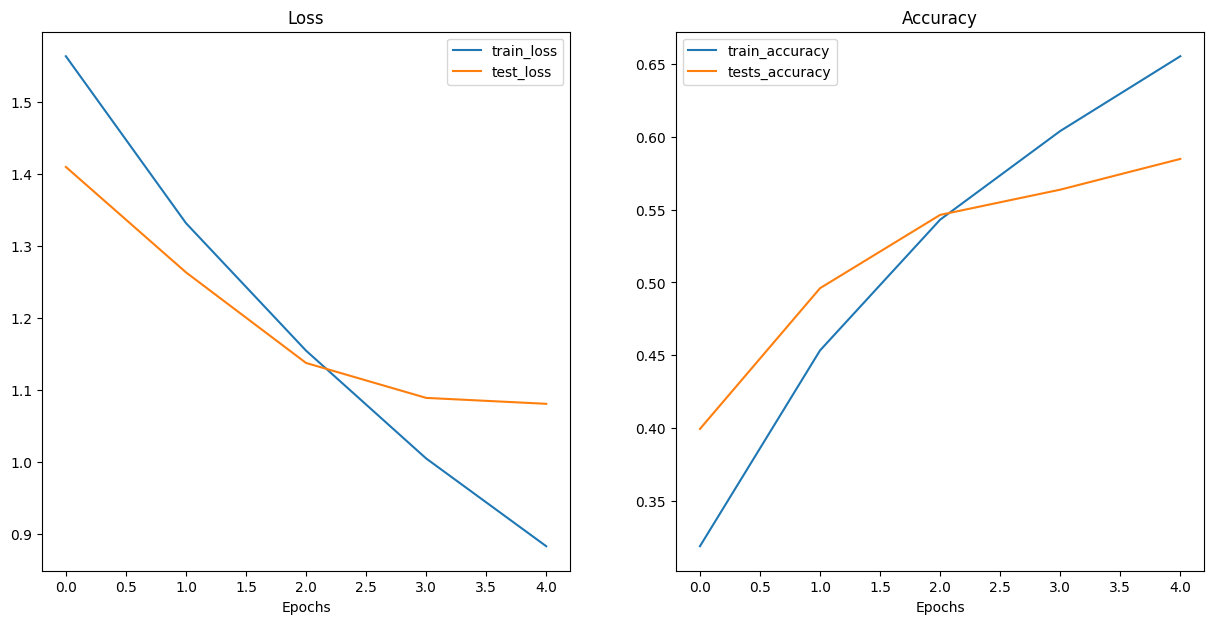

In [ ]:
plot_loss_curves(model_0_results)

## Train our model with Data Augmentation

In [ ]:
# Create train transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [ ]:
### Creating train and test Dataset's and Dataloader's

# Turn image folder into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data

(Dataset ImageFolder
     Number of datapoints: 12361
     Root location: /content/facial_emotion_dataset/dataset/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 3092
     Root location: /content/facial_emotion_dataset/dataset/test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [ ]:
# Turn Datasets into DataLoaders
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ce140107b80>,
 <torch.utils.data.dataloader.DataLoader at 0x7ce14af814e0>)

In [ ]:
### Model 2 Construction and Training
torch.manual_seed(42)
model_1 = TinyFER(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyFER(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=31360, out_features=6, bias=True)
  )
)

In [ ]:
### Train the model for 25 Epochs
NUM_EPOCHS = 25

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
start_time = timer()
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        epochs=NUM_EPOCHS)
end_time = timer()

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5729 | train_acc: 0.3238 | test_loss: 1.4191 | test_acc: 0.4174
Epoch: 2 | train_loss: 1.4716 | train_acc: 0.3830 | test_loss: 1.3331 | test_acc: 0.4607
Epoch: 3 | train_loss: 1.3768 | train_acc: 0.4285 | test_loss: 1.2646 | test_acc: 0.4820
Epoch: 4 | train_loss: 1.3105 | train_acc: 0.4688 | test_loss: 1.2350 | test_acc: 0.5138
Epoch: 5 | train_loss: 1.2558 | train_acc: 0.4920 | test_loss: 1.1516 | test_acc: 0.5339
Epoch: 6 | train_loss: 1.2141 | train_acc: 0.5184 | test_loss: 1.1196 | test_acc: 0.5417
Epoch: 7 | train_loss: 1.1861 | train_acc: 0.5289 | test_loss: 1.1342 | test_acc: 0.5468
Epoch: 8 | train_loss: 1.1676 | train_acc: 0.5405 | test_loss: 1.1114 | test_acc: 0.5484
Epoch: 9 | train_loss: 1.1263 | train_acc: 0.5606 | test_loss: 1.0816 | test_acc: 0.5629
Epoch: 10 | train_loss: 1.1184 | train_acc: 0.5729 | test_loss: 1.0895 | test_acc: 0.5640
Epoch: 11 | train_loss: 1.0980 | train_acc: 0.5747 | test_loss: 1.0978 | test_acc: 0.5671
Epoch: 12 | train_l

In [ ]:
torch.save(model_1.state_dict(), 'model_1.pth')

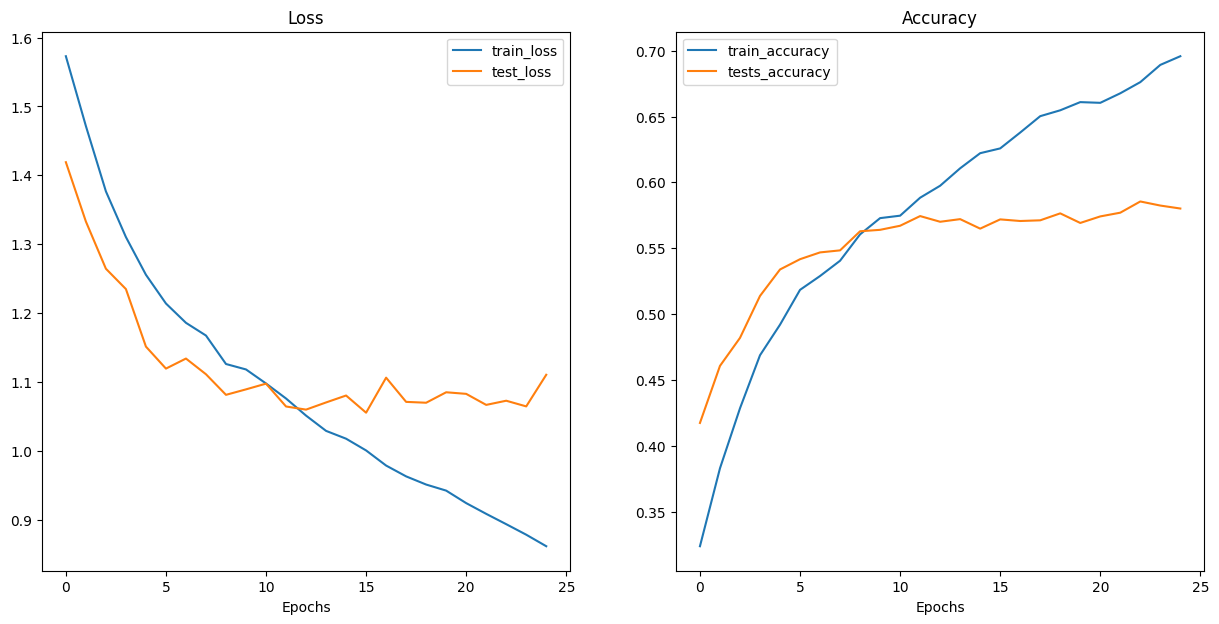

In [ ]:
# Plot loss curve for Model 1
plot_loss_curves(model_1_results)

## Creating a better Neural netwrok architecture with more layes

In [ ]:
class FacialEmotionRecognitionV0(nn.Module):
  def __init__(self, input_shape: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(input_shape, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64), # Batch Normalization
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) # Pooling to reduce size
    )

    # Second Convolutional Block
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    # Third Convolutional block
    self.conv_block_3 = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    # Fourth Convolutional Block
    self.conv_block_4 = nn.Sequential(
        nn.Conv2d(256, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    # Global Average Pooling Layer
    self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

    # Fully Connected Layer for Classification
    self.fc = nn.Linear(512, output_shape)

  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.conv_block_3(x)
    x = self.conv_block_4(x)

    # global average pooling
    x = self.global_avg_pool(x)

    # Flatten the output
    x = x.view(x.size(0), -1)

    # Final Fully connected layer (classifier)
    x = self.fc(x)
    return x

In [ ]:
# Train our Model 2

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set teh number of epochs
NUM_EPOCHS = 50

# Recreate an instance of FacialEmotionRecognitionV0
model_2 = FacialEmotionRecognitionV0(input_shape=3,
                                     output_shape=len(train_data_augmented.classes)).to(device)

model_2

# Setup Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.001)

# Start the timer
start_time = timer()
model_2_results = train(model=model_2,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print the total time
end_time = timer()

print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6404 | train_acc: 0.2750 | test_loss: 1.5734 | test_acc: 0.3281
Epoch: 2 | train_loss: 1.5831 | train_acc: 0.3012 | test_loss: 1.6241 | test_acc: 0.2783
Epoch: 3 | train_loss: 1.5525 | train_acc: 0.3158 | test_loss: 1.4848 | test_acc: 0.3199
Epoch: 4 | train_loss: 1.5376 | train_acc: 0.3243 | test_loss: 1.5046 | test_acc: 0.3070
Epoch: 5 | train_loss: 1.5237 | train_acc: 0.3280 | test_loss: 1.4729 | test_acc: 0.3831
Epoch: 6 | train_loss: 1.4998 | train_acc: 0.3461 | test_loss: 1.4225 | test_acc: 0.4095
Epoch: 7 | train_loss: 1.4420 | train_acc: 0.3951 | test_loss: 1.4128 | test_acc: 0.4220
Epoch: 8 | train_loss: 1.3551 | train_acc: 0.4370 | test_loss: 1.3847 | test_acc: 0.4256
Epoch: 9 | train_loss: 1.2649 | train_acc: 0.4915 | test_loss: 1.3193 | test_acc: 0.4605
Epoch: 10 | train_loss: 1.1677 | train_acc: 0.5344 | test_loss: 1.0561 | test_acc: 0.5805
Epoch: 11 | train_loss: 1.0935 | train_acc: 0.5643 | test_loss: 1.0632 | test_acc: 0.5851
Epoch: 12 | train_l

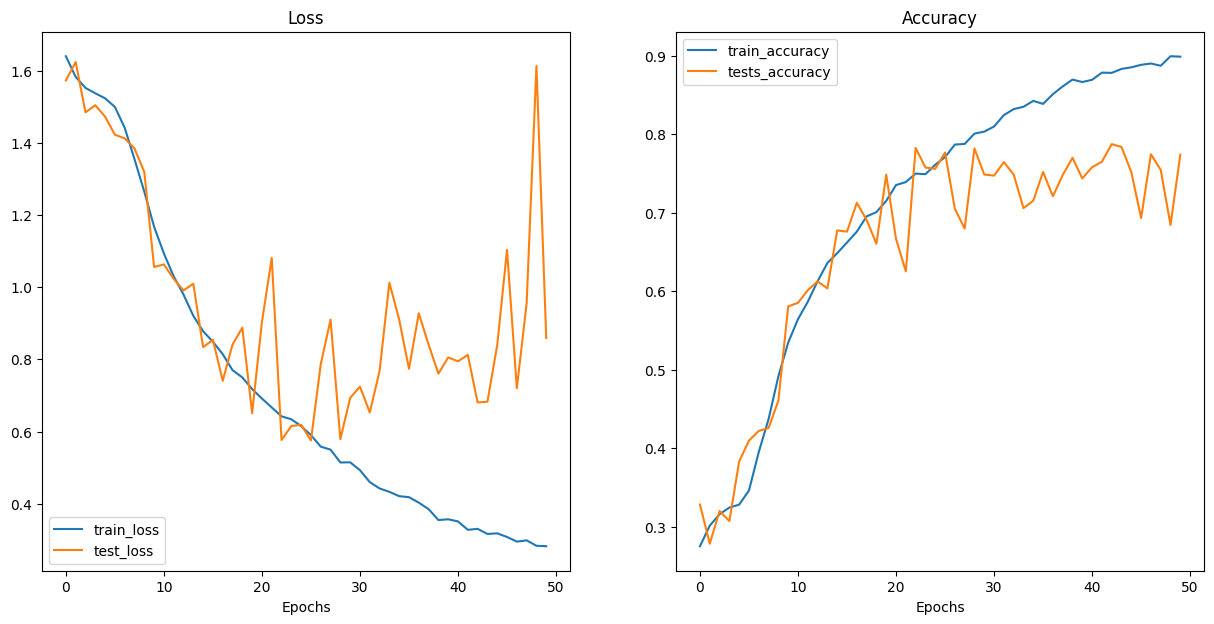

In [ ]:
# Plot loss curves of Model 3
plot_loss_curves(model_2_results)

In [ ]:
torch.save(model_2.state_dict(), "model_2.pth")

## Fine tuning hyperparameter

In [ ]:
# Increasing the batch size

train_dataloader_augmented = DataLoader(dataset=train_data,
                              batch_size=64, # 32 -> 64
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=64, # 32 -> 64
                             num_workers=os.cpu_count(),
                             shuffle=False)

In [ ]:
# Train our Model 3

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set teh number of epochs
NUM_EPOCHS = 50

# Recreate an instance of FacialEmotionRecognitionV0
model_4 = FacialEmotionRecognitionV0(input_shape=3,
                                     output_shape=len(train_data_augmented.classes)).to(device)


# Setup Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_4.parameters(), lr=0.01) # Reducing the learning rate

# Start the timer
start_time = timer()
model_4_results = train(model=model_4,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,)

# End the timer and print the total time
end_time = timer()

print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.8521 | train_acc: 0.2510 | test_loss: 1.8071 | test_acc: 0.2512
Epoch: 2 | train_loss: 1.6571 | train_acc: 0.3381 | test_loss: 1.8974 | test_acc: 0.2895
Epoch: 3 | train_loss: 1.3598 | train_acc: 0.4750 | test_loss: 1.5015 | test_acc: 0.4261
Epoch: 4 | train_loss: 1.2003 | train_acc: 0.5408 | test_loss: 1.2437 | test_acc: 0.5258
Epoch: 5 | train_loss: 1.1078 | train_acc: 0.5815 | test_loss: 1.0930 | test_acc: 0.5800
Epoch: 6 | train_loss: 1.0335 | train_acc: 0.6082 | test_loss: 1.1411 | test_acc: 0.5741
Epoch: 7 | train_loss: 0.9783 | train_acc: 0.6320 | test_loss: 1.0501 | test_acc: 0.6018
Epoch: 8 | train_loss: 0.9204 | train_acc: 0.6545 | test_loss: 1.1623 | test_acc: 0.5761
Epoch: 9 | train_loss: 0.8761 | train_acc: 0.6717 | test_loss: 1.0799 | test_acc: 0.6051
Epoch: 10 | train_loss: 0.8208 | train_acc: 0.6913 | test_loss: 1.0890 | test_acc: 0.6009
Epoch: 11 | train_loss: 0.7607 | train_acc: 0.7170 | test_loss: 1.0079 | test_acc: 0.6323
Epoch: 12 | train_l

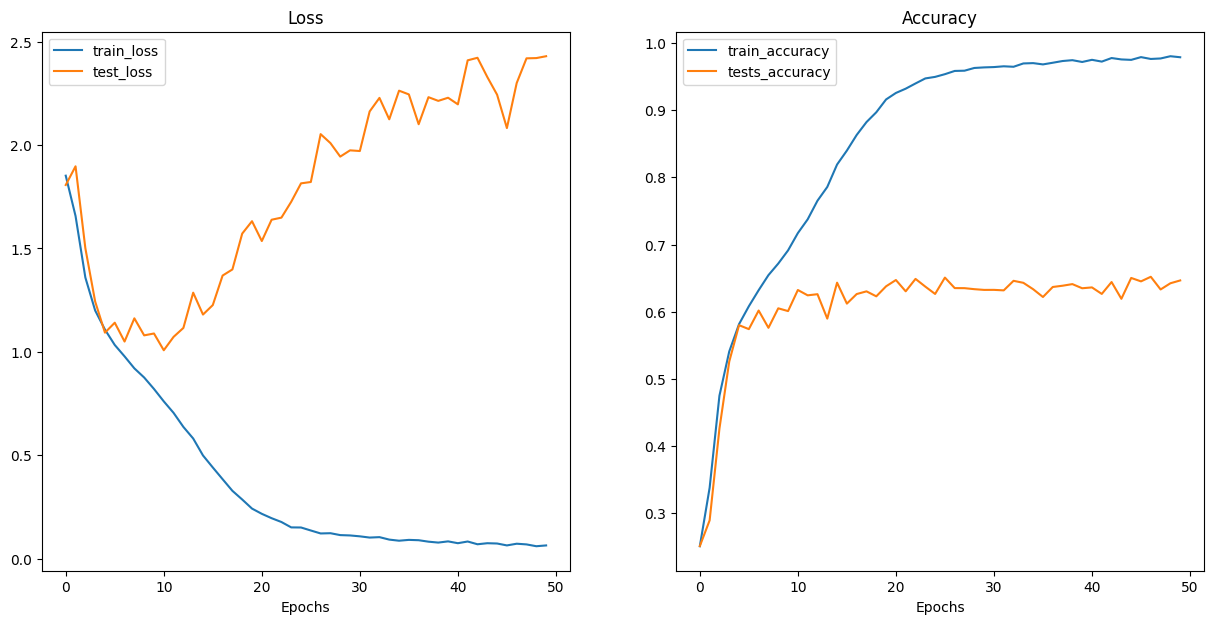

In [ ]:
plot_loss_curves(model_4_results)

In [ ]:
# Adding Dropout layers to reduce overfitting
class FacialEmotionRecognitionV1(nn.Module):
    def __init__(self, input_shape: int, output_shape: int):
        super().__init__()

        # First Convolutional Block
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(input_shape, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3)  # Dropout to prevent overfitting
        )

        # Second Convolutional Block
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3)
        )

        # Third Convolutional Block
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.4)
        )

        # Fourth Convolutional Block
        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.4)
        )

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        # Fully Connected Layer
        self.fc1 = nn.Linear(256, 128)  # Reduced size
        self.fc2 = nn.Linear(128, output_shape)

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.conv_block_4(x)

        # Global Average Pooling
        x = self.global_avg_pool(x)

        # Flattening
        x = x.view(x.size(0), -1)

        # Fully Connected Layers with Dropout
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = nn.Dropout(0.5)(x)  # Dropout in fully connected layers
        x = self.fc2(x)

        return x

In [ ]:
# Train our Model 5

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set teh number of epochs
NUM_EPOCHS = 50

# Recreate an instance of FacialEmotionRecognitionV0
model_5 = FacialEmotionRecognitionV1(input_shape=3,
                                     output_shape=len(train_data_augmented.classes)).to(device)


# Setup Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_5.parameters(), lr=0.001)

# Start the timer
start_time = timer()
model_5_results = train(model=model_5,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,)

# End the timer and print the total time
end_time = timer()

print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5779 | train_acc: 0.3168 | test_loss: 2.2197 | test_acc: 0.2073
Epoch: 2 | train_loss: 1.4786 | train_acc: 0.3452 | test_loss: 1.5637 | test_acc: 0.3103
Epoch: 3 | train_loss: 1.4297 | train_acc: 0.3714 | test_loss: 1.4406 | test_acc: 0.3687
Epoch: 4 | train_loss: 1.3772 | train_acc: 0.4029 | test_loss: 1.4911 | test_acc: 0.3655
Epoch: 5 | train_loss: 1.2995 | train_acc: 0.4491 | test_loss: 1.3245 | test_acc: 0.4584


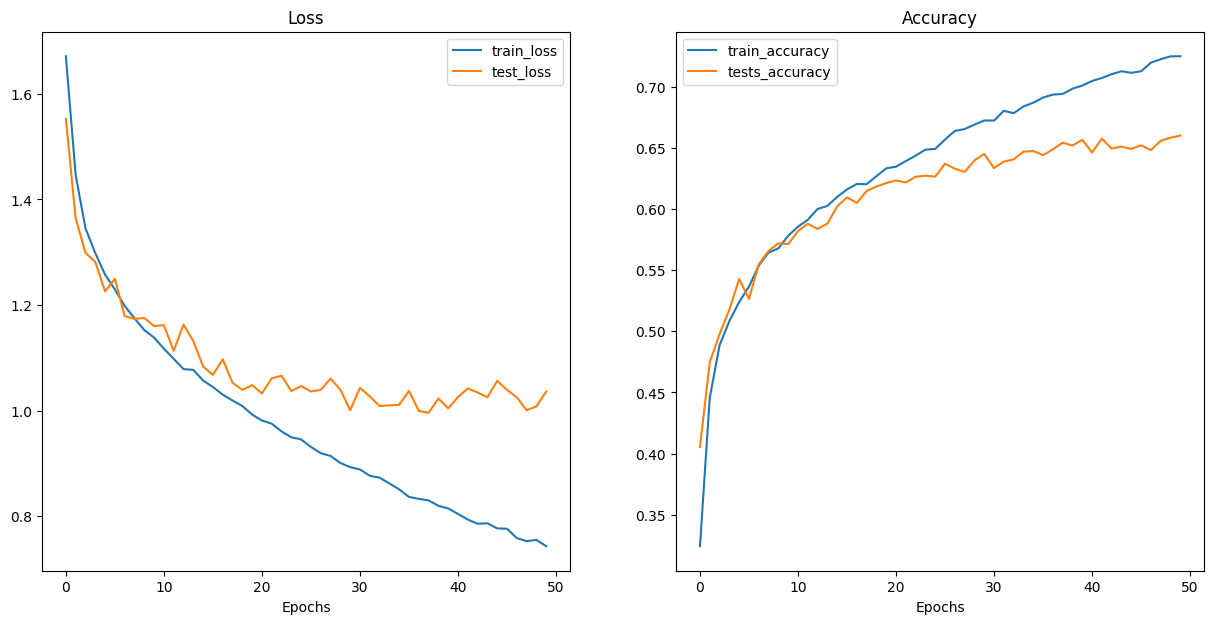

In [ ]:
plot_loss_curves(model_5_results)

In [ ]:
# Save the model state dictionary
torch.save(model_5.state_dict(), 'model_5.pth')

## Transfer learning - using pretrained model to train on our Custom image dataset

### Using torchvision pretrained models (MovileNetV3)

In [ ]:
# Store the pretrained-weights of MobilNetV3
weights = torchvision.models.MobileNet_V3_Small_Weights.DEFAULT
weights

MobileNet_V3_Small_Weights.IMAGENET1K_V1

In [ ]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()

# Use ImageFolder to create datasets(s) for our preatrined model
train_data = datasets.ImageFolder(root=train_dir, transform=auto_transforms)
test_data = datasets.ImageFolder(root=test_dir, transform=auto_transforms)

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create training and testing DataLoaders
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

In [ ]:
# Setup the model with pretrained weights and sent it to the target device
model_6_mobnv3 = torchvision.models.mobilenet_v3_small(weights=weights).to(device)

In [ ]:
torchinfo.summary(
    model=model_6_mobnv3,
    input_size=(32, 3, 48, 48),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
MobileNetV3 (MobileNetV3)                                    [32, 3, 48, 48]      [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 48, 48]      [32, 576, 2, 2]      --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 48, 48]      [32, 16, 24, 24]     --                   True
│    │    └─Conv2d (0)                                       [32, 3, 48, 48]      [32, 16, 24, 24]     432                  True
│    │    └─BatchNorm2d (1)                                  [32, 16, 24, 24]     [32, 16, 24, 24]     32                   True
│    │    └─Hardswish (2)                                    [32, 16, 24, 24]     [32, 16, 24, 24]     --                   --
│    └─InvertedResidual (1)                                  [32, 16, 24, 24]     [32, 16, 12,

In [ ]:
# Freeze all the base layers
for param in model_6_mobnv3.features.parameters():
  param.requires_grad = False


In [ ]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the Length of class names
output_shape = len(train_data.classes)

# Recreate the classifier layer
model_6_mobnv3.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=576, out_features=output_shape, bias=True)
).to(device)

In [ ]:
# Do a summary *after* freezing the features and changing the output classifier layer
summary(model_6_mobnv3,
        input_size=(32, 3, 48, 48), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
MobileNetV3 (MobileNetV3)                                    [32, 3, 48, 48]      [32, 7]              --                   Partial
├─Sequential (features)                                      [32, 3, 48, 48]      [32, 576, 2, 2]      --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 48, 48]      [32, 16, 24, 24]     --                   False
│    │    └─Conv2d (0)                                       [32, 3, 48, 48]      [32, 16, 24, 24]     (432)                False
│    │    └─BatchNorm2d (1)                                  [32, 16, 24, 24]     [32, 16, 24, 24]     (32)                 False
│    │    └─Hardswish (2)                                    [32, 16, 24, 24]     [32, 16, 24, 24]     --                   --
│    └─InvertedResidual (1)                                  [32, 16, 24, 24]     [32, 

In [ ]:
### Train the model

# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_6_mobnv3.parameters(), lr=0.001)

# Set the random seeds()
torch.manual_seed(42)
torch.cuda.manual_seed(42)

EPOCHS = 50

# Start the timer
start_time = timer()
model_6_mobnv3_results = train(model_6_mobnv3,
                               train_dataloader=train_loader,
                               test_dataloader=test_dataloader,
                               loss_fn=loss_fn,
                               optimizer=optimizer,
                               epochs=EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5716 | train_acc: 0.3908 | test_loss: 2.0200 | test_acc: 0.1651
Epoch: 2 | train_loss: 1.4868 | train_acc: 0.4275 | test_loss: 2.0191 | test_acc: 0.1649
Epoch: 3 | train_loss: 1.4646 | train_acc: 0.4391 | test_loss: 2.0214 | test_acc: 0.1889
Epoch: 4 | train_loss: 1.4537 | train_acc: 0.4427 | test_loss: 1.9907 | test_acc: 0.1896
Epoch: 5 | train_loss: 1.4578 | train_acc: 0.4351 | test_loss: 2.0018 | test_acc: 0.1824
Epoch: 6 | train_loss: 1.4505 | train_acc: 0.4397 | test_loss: 1.9946 | test_acc: 0.1935
Epoch: 7 | train_loss: 1.4541 | train_acc: 0.4431 | test_loss: 2.0092 | test_acc: 0.2067
Epoch: 8 | train_loss: 1.4524 | train_acc: 0.4416 | test_loss: 2.0385 | test_acc: 0.1995
Epoch: 9 | train_loss: 1.4481 | train_acc: 0.4447 | test_loss: 2.0384 | test_acc: 0.1911
Epoch: 10 | train_loss: 1.4509 | train_acc: 0.4438 | test_loss: 2.0161 | test_acc: 0.2004
Epoch: 11 | train_loss: 1.4531 | train_acc: 0.4408 | test_loss: 2.0097 | test_acc: 0.1938
Epoch: 12 | train_l

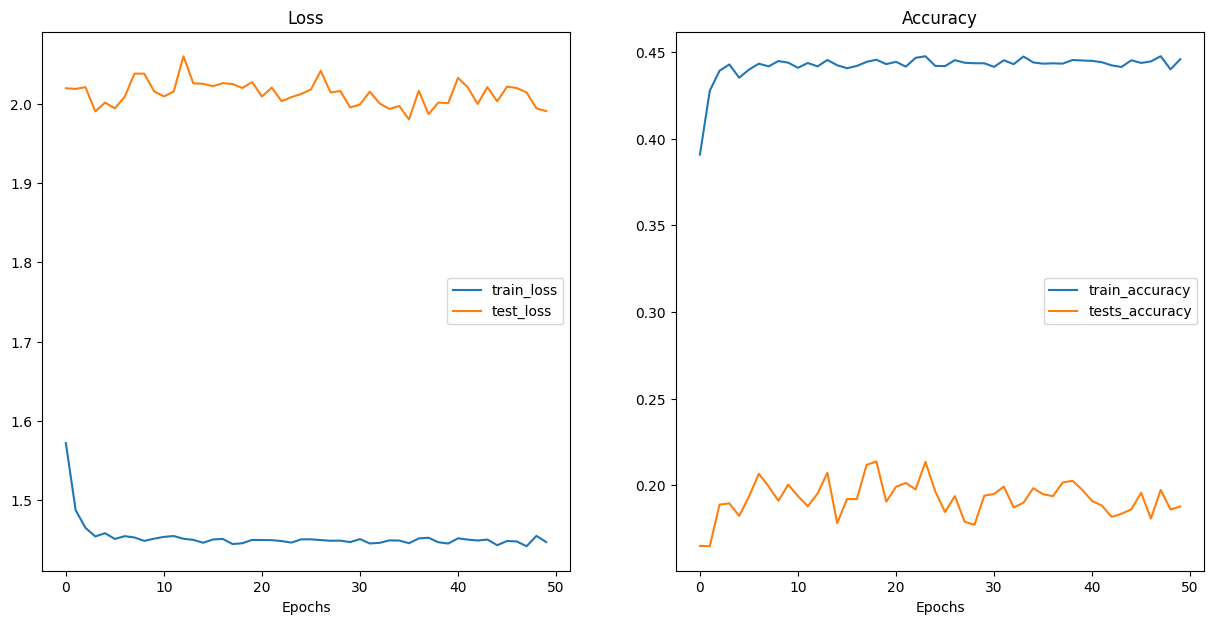

In [ ]:
plot_loss_curves(model_6_mobnv3_results)

## Compare model results

In [ ]:
# Make prediction
# Load your model
# Load the model weights
model_2.load_state_dict(torch.load("/content/model_2.pth"))
model_2.eval()

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the input size of your model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess the image
image_path = '/content/download.jpg'  # Replace with your image path
image = Image.open(image_path)
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

image_tensor = image_tensor.to(device)

# Make the prediction
with torch.no_grad():
    output = model_2(image_tensor)
    _, predicted = torch.max(output, 1)

# Print the predicted class
print(f'Predicted class index: {train_data.classes[predicted.item()]}')

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()

NameError: name 'model_2' is not defined

Predicted class index: Sad


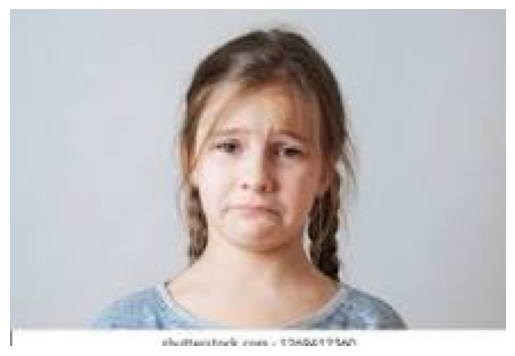

In [ ]:
# Load and preprocess the image
image_path = '/content/images.jpg'  # Replace with your image path
image = Image.open(image_path)
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

image_tensor = image_tensor.to(device)

# Make the prediction
with torch.no_grad():
    output = model_2(image_tensor)
    _, predicted = torch.max(output, 1)

# Print the predicted class
print(f'Predicted class index: {train_data.classes[predicted.item()]}')

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()

<ipython-input-37-49985bad7f26>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_5.load_state_dict(torch.load("/content/model_5.pth"))


Predicted class index: Sad


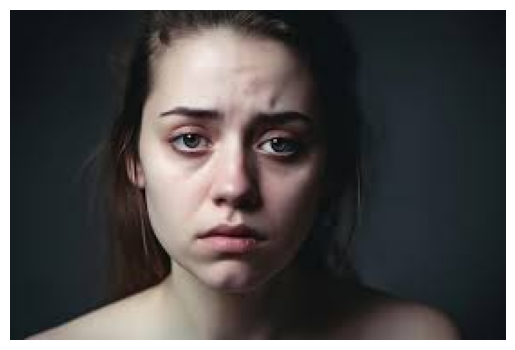

In [ ]:
# Make prediction
# Load your model
# Load the model weights
model_5.load_state_dict(torch.load("/content/model_5.pth"))
model_5.eval()

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the input size of your model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess the image
image_path = '/content/download.jpg'  # Replace with your image path
image = Image.open(image_path)
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

image_tensor = image_tensor.to(device)

# Make the prediction
with torch.no_grad():
    output = model_5(image_tensor)
    _, predicted = torch.max(output, 1)

# Print the predicted class
print(f'Predicted class index: {train_data.classes[predicted.item()]}')

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()